In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
import joblib # for saving the scaler
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow.lite as tflite
import random

Seed = 30
random.seed(Seed)
np.random.seed(Seed)
tf.random.set_seed(Seed)
os.environ['TF_DETERMINISTIC_OPS'] ='1'
os.environ['TF_CUDNN_DETERMINISTIC'] ='1'

2025-07-03 04:08:39.379809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 04:08:39.391399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 04:08:39.422163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751515719.459983   10170 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751515719.467669   10170 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751515719.490836   10170 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
def preprocess_stock_data(csv_path,date_column ='Date',close_column = 'Close',test_size = 0.2,validation_size = 0.1,time_steps=60,scaler_output_file ='/workspaces/stock_price_prediction.model/Output/sbi_scaler.pkl'):
    """Prepare stock market price data for time series modelling, with training, validation, and test split.
                          
       Args:
            csv_path (str): Path to the CSV file containing the data.
            date_column(str): Name of the date column in the CSV
            close_column(str): Name of the closing price in the CSV
            test_size(float) : proportion of dividing the dataset
            scaler_output_file(str): Path to save the fitted MinMaxScaler instance

            Return:

            X_train(numpy.ndarray): training data
            y_train (numpy.ndarray): Training labels.
            X_val (numpy.ndarray): Validation data (features).
            y_val (numpy.ndarray): Validation labels.
            X_test (numpy.ndarray): Testing data (features).
            y_test (numpy.ndarray): Testing labels.
    """
    try:
         #Load the dataset

        if not os.path.exists(csv_path):
            raise FileNotFoundError(f'CSV file not found at path:{csv_path}')
        data = pd.read_csv(csv_path, parse_dates=[date_column])
        data.sort_values(by=date_column, inplace=True)
        print(f'CSV file successfully loaded. Column:{data.columns}')
    except Exception as e:
        raise  ValueError(f"error reading CSV file or parsing date column'{date_column}':{e}")
    # Validation columns    
    if date_column not in data.columns or close_column not in data.columns:

        raise ValueError(f"Columns '{date_column}' or '{close_column}' not found in dataset. Available columns: {data.columns}")

    #Extract and scale
    close_prices = data[close_column].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_close = scaler.fit_transform(close_prices)
    # Save the scaler
    try:
    

        # Save the scaler to a file
        with open(scaler_output_file, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler saved to {scaler_output_file}")
    except Exception as e:
        raise IOError(f'Error during scaling or saving scaler:{e}')
    # Create sequences of time_steps
    X, y = [], []
    try:
        for i in range(time_steps, len(scaled_close)):
            X.append(scaled_close[i - time_steps:i])
            y.append(scaled_close[i])
    except Exception as e:
        raise ValueError(f"Error creating sequences of time_steps: {e}")
    
    X, y = np.array(X), np.array(y)
    
    # Split data into train, validation, and test sets
    try:
        total_size = len(X)
        test_size_count = int(test_size * total_size)
        validation_size_count = int(validation_size * total_size)

        train_end_idx = total_size - test_size_count - validation_size_count
        val_end_idx = total_size - test_size_count

        X_train, X_val, X_test = X[:train_end_idx], X[train_end_idx:val_end_idx], X[val_end_idx:]
        y_train, y_val, y_test = y[:train_end_idx], y[train_end_idx:val_end_idx], y[val_end_idx:]

        # Adjust splits to match desired sample sizes
        train_samples = 554
        val_samples = 55
        test_samples = 84

        X_train, y_train = X[:train_samples], y[:train_samples]
        X_val, y_val = X[train_samples:train_samples + val_samples], y[train_samples:train_samples + val_samples]
        X_test, y_test = X[train_samples + val_samples:train_samples + val_samples + test_samples], y[train_samples + val_samples:train_samples + val_samples + test_samples]
    except Exception as e:
        raise ValueError(f"Error splitting data into train, validation, and test sets: {e}")
    print(f"Data split: {len(X_train)} training samples, {len(X_val)} validation samples, {len(X_test)} testing samples")
    return X_train, y_train, X_val, y_val, X_test, y_test





    

In [4]:

data = '/workspaces/stock_price_prediction.model/Inputs/sbi_data.csv'

try:
    X_train, y_train, X_val, y_val, X_test, y_test = preprocess_stock_data(
        data, 
        date_column='Date', 
        close_column='Close', 
        test_size=0.2, 
        time_steps=60, 
        scaler_output_file='/workspaces/stock_price_prediction.model/Output/sbi_scaler.pkl'
    )

    # Outputs
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_train shape: {X_val.shape}, y_train shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"Unexpected Error: {e}")

CSV file successfully loaded. Column:Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Scaler saved to /workspaces/stock_price_prediction.model/Output/sbi_scaler.pkl
Data split: 554 training samples, 55 validation samples, 72 testing samples
X_train shape: (554, 60, 1), y_train shape: (554, 1)
X_train shape: (55, 60, 1), y_train shape: (55, 1)
X_test shape: (72, 60, 1), y_test shape: (72, 1)


In [5]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (554, 60, 1)
y_train shape: (554, 1)


Input shape is valid: (554, 60, 1)
Input shape is valid: (55, 60, 1)
Epoch 1/50


2025-07-03 04:25:40.682634: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 - 4s - 106ms/step - loss: 0.0429 - mean_absolute_error: 0.1403 - mean_absolute_percentage_error: 33.3816 - symmetric_mean_absolute_percentage_error: 35.8267 - val_loss: 0.0086 - val_mean_absolute_error: 0.0807 - val_mean_absolute_percentage_error: 10.0856 - val_symmetric_mean_absolute_percentage_error: 11.2184
Epoch 2/50
35/35 - 1s - 22ms/step - loss: 0.0087 - mean_absolute_error: 0.0689 - mean_absolute_percentage_error: 16.3886 - symmetric_mean_absolute_percentage_error: 15.7686 - val_loss: 0.0026 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 5.1616 - val_symmetric_mean_absolute_percentage_error: 5.2961
Epoch 3/50
35/35 - 1s - 35ms/step - loss: 0.0067 - mean_absolute_error: 0.0592 - mean_absolute_percentage_error: 13.6362 - symmetric_mean_absolute_percentage_error: 13.4849 - val_loss: 0.0049 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.8735 - val_symmetric_mean_absolute_percentage_error: 7.2404
Epoch 4/50
35/35 - 1s - 25ms/s

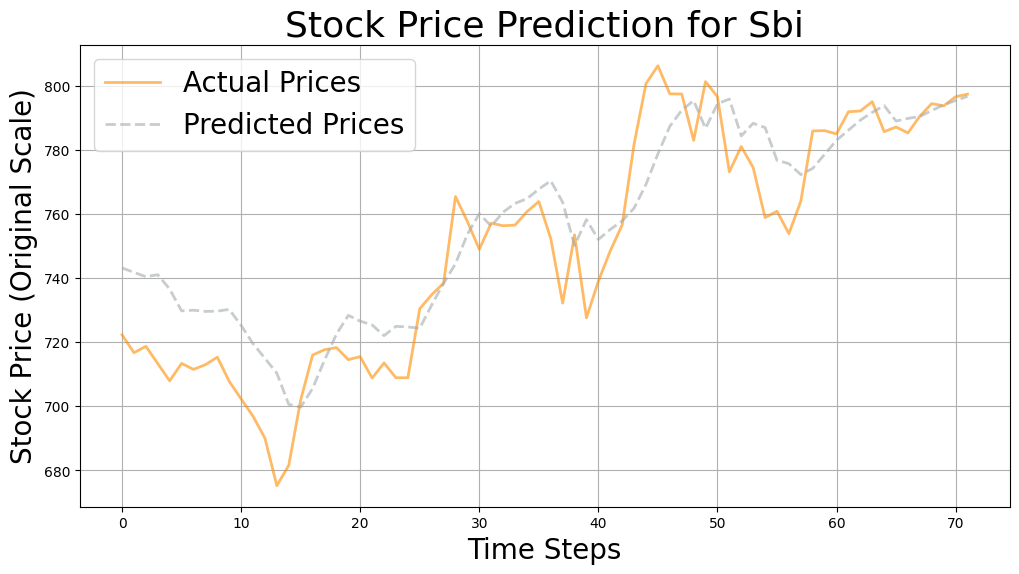

In [6]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import tensorflow as tf
import joblib
import numpy as np
import os

@tf.keras.utils.register_keras_serializable(package="Custom", name="symmetric_mean_absolute_percentage_error")
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """
    Computes Symmetric Mean Absolute Percentage Error (SMAPE).

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.

    Returns:
        SMAPE as a TensorFlow tensor.
    """
    numerator = tf.abs(y_true - y_pred)
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2
    smape = tf.reduce_mean(numerator / denominator) * 100
    return smape


class StockPricePredictor_SBI:
    def __init__(self, input_shape, learning_rate=0.01341034226855941, num_layers=2, units=32):
        self.input_shape = input_shape  # Should be (time_steps, features)
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.units = units
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        for i in range(self.num_layers):
            # Add LSTM layers
            return_sequences = i < (self.num_layers - 1)
            model.add(LSTM(self.units, activation='relu', return_sequences=return_sequences, input_shape=self.input_shape))
            model.add(Dropout(0.2))  # Regularization

        # Output layer for regression (single output: close value)
        model.add(Dense(1))

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[
                tf.keras.metrics.MeanAbsoluteError(),
                tf.keras.metrics.MeanAbsolutePercentageError(),
                symmetric_mean_absolute_percentage_error  # Custom SMAPE metric
            ]
        )
        return model

    def train(self, X_train, y_train, batch_size=16, epochs=50, validation_data=None, patience=15):
        """
        Trains the model with an EarlyStopping callback.
        
        Args:
            X_train: Training input data.
            y_train: Training target data.
            batch_size: Batch size for training.
            epochs: Maximum number of training epochs.
            validation_data: Tuple (X_val, y_val) for validation.
            patience: Number of epochs with no improvement after which training will be stopped.
        
        Returns:
            History object containing training details.
        """
        X_train = self._validate_and_reshape(X_train, expected_shape=(None, *self.input_shape))
        if validation_data:
            X_val = self._validate_and_reshape(validation_data[0], expected_shape=(None, *self.input_shape))
            validation_data = (X_val, validation_data[1])

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )

        history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=validation_data,
            callbacks=[early_stopping],
            verbose=2
        )
        return history

    def predict(self, X):
        X = self._validate_and_reshape(X, expected_shape=(None, *self.input_shape))
        return self.model.predict(X)

    def save(self, model_path):
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

    @staticmethod
    def load(model_path, scaler_path):
        model = load_model(model_path, custom_objects={
            "symmetric_mean_absolute_percentage_error": symmetric_mean_absolute_percentage_error
        })
        print(f"Model loaded from {model_path}")

        scaler = joblib.load(scaler_path)
        print(f"Scaler loaded from {scaler_path}")

        return model, scaler

    def _validate_and_reshape(self, X, expected_shape):
        if len(X.shape) == 2:
            reshaped = X[..., np.newaxis]
            print(f"Reshaped input from {X.shape} to {reshaped.shape}")
            return reshaped
        elif len(X.shape) == len(expected_shape):
            print(f"Input shape is valid: {X.shape}")
            return X
        else:
            raise ValueError(f"Invalid input shape {X.shape}. Expected shape {expected_shape}.")






# In[15]:


data_path_hdfc = "/workspaces/stock_price_prediction.model/Inputs/sbi_data.csv"

#output_file = "scaled_stock_data_close_option.pkl"





# In[ ]:





# In[16]:


if __name__ == "__main__":
    # Example input data
    input_shape = (60, 1)  # 60 time steps, 1 feature (e.g., close price)
    predictor = StockPricePredictor_SBI(input_shape=input_shape)

    # Training
    predictor.train(X_train, y_train, validation_data=(X_val, y_val))

    # Save the model
    model_path = "/workspaces/stock_price_prediction.model/Output/stock_price_Sbi_model.keras"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    scaler_path = "/workspaces/stock_price_prediction.model/Output/sbi_scaler.pkl"
    predictor.save(model_path)

    # Load model and scaler for inference
    loaded_model, loaded_scaler = StockPricePredictor_SBI.load(model_path, scaler_path)

    # Predict on test data
    predictions = loaded_model.predict(X_test)
    predictions_rescaled = loaded_scaler.inverse_transform(predictions).astype('float32')

    # Rescale test labels for evaluation (if scaled)
    y_test_rescaled = loaded_scaler.inverse_transform(y_test.reshape(-1, 1)).astype('float32')

    # Print predictions
    print("Predictions (rescaled):", predictions_rescaled.astype('float32'))

    # Evaluate metrics on test data
    metrics = loaded_model.evaluate(X_test, y_test, verbose=2)
    metric_names = loaded_model.metrics_names  # Get metric names for better interpretability

    # Display metrics
    for name, value in zip(metric_names, metrics):
        print(f"{name}: {value:.4f}")

    # Compute and display custom SMAPE manually for rescaled predictions
    smape_manual = symmetric_mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)
    print(f"SMAPE (manual, rescaled): {smape_manual.numpy():.4f}")


# In[ ]:





# In[17]:


plt.figure(figsize=(12, 6))
plt.plot(loaded_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Prices", color="darkorange", alpha=0.6, linewidth=2)
plt.plot(loaded_scaler.inverse_transform(predictions.reshape(-1, 1)), label="Predicted Prices", color="#A3AAAE", alpha=0.6, linestyle="--", linewidth=2)
plt.title("Stock Price Prediction for Sbi",fontsize = 26)
plt.xlabel("Time Steps",fontsize = 20)
plt.ylabel("Stock Price (Original Scale)",fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()
